### Imports

In [71]:
#Spark Imports
import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

#Python Standard Libs Imports
import json
import urllib2
import sys
from datetime import datetime
from os.path import isfile, join, splitext
from glob import glob

#Imports to enable visualizations
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Functions

#### Basic Functions

In [3]:
def rename_columns(df, list_of_tuples):
    for (old_col, new_col) in list_of_tuples:
        df = df.withColumnRenamed(old_col, new_col)
    return df

def read_folders(path, sqlContext, sc, initial_date, final_date, folder_suffix):
    extension = splitext(path)[1]

    if extension == "":
        path_pattern = path + "/*/part-*"
        if "hdfs" in path:
            URI = sc._gateway.jvm.java.net.URI
            Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
            FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
            Configuration = sc._gateway.jvm.org.apache.hadoop.conf.Configuration

            hdfs = "/".join(path_pattern.split("/")[:3])
            dir = "/" + "/".join(path_pattern.split("/")[3:])

            fs = FileSystem.get(URI(hdfs), Configuration())

            status = fs.globStatus(Path(dir))

            files = map(lambda file_status: str(file_status.getPath()), status)

        else:
            files = glob(path_pattern)

        #print initial_date, final_date
        #print datetime.strptime(files[0].split('/')[-2],('%Y_%m_%d' + folder_suffix))

        files = filter(lambda f: initial_date <= datetime.strptime(f.split("/")[-2], ('%Y_%m_%d' + folder_suffix)) <=
                                 final_date, files)
        
        #print len(files)
        #print files
        if folder_suffix == '_od':
            return reduce(lambda df1, df2: df1.unionAll(df2),
                      map(lambda f: read_hdfs_folder(sqlContext,f), files))
        else:
            return reduce(lambda df1, df2: df1.unionAll(df2),
                      map(lambda f: read_buste_data_v3(sqlContext,f), files))
    else:
        return read_file(path, sqlContext)

def read_hdfs_folder(sqlContext, folderpath):
    data_frame = sqlContext.read.csv(folderpath, header=True,
                                     inferSchema=True,nullValue="-")
    return data_frame

def read_buste_data_v3(sqlContext, folderpath):
    data_frame = read_hdfs_folder(sqlContext,folderpath)
    data_frame = data_frame.withColumn("date", F.unix_timestamp(F.col("date"),'yyyy_MM_dd'))
    
    return data_frame

def printdf(df,l=10):
    return df.limit(l).toPandas()

def get_timestamp_in_tz(unixtime_timestamp,ts_format,tz):
    return F.from_utc_timestamp(F.from_unixtime(unixtime_timestamp, ts_format),tz)


#### Analysis Functions

In [64]:
def get_otp_itineraries(otp_url,o_lat,o_lon,d_lat,d_lon,date,time,verbose=False):
    otp_http_request = 'routers/ctba/plan?fromPlace={},{}&toPlace={},{}&mode=TRANSIT,WALK&date={}&time={}'
    otp_request_url = otp_url + otp_http_request.format(o_lat,o_lon,d_lat,d_lon,date,time)
    if verbose:
        print otp_request_url
    return json.loads(urllib2.urlopen(otp_request_url).read())

def get_otp_suggested_trips(od_matrix,otp_url):
    trips_otp_response = {}
    counter = 0
    for row in od_matrix.collect():
        id=long(row['user_trip_id'])
        start_time = row['o_base_datetime'].split(' ')[1]
        trip_plan = get_otp_itineraries(otp_url,row['o_shape_lat'], row['o_shape_lon'], row['shapeLat'], row['shapeLon'],row['date'],start_time)
        trips_otp_response[id] = trip_plan
        counter+=1

    return trips_otp_response

def advance_od_matrix_start_time(od_matrix,extra_seconds):
    return od_matrix.withColumn('o_datetime', F.concat(F.col('date'), F.lit(' '), F.col('o_timestamp'))) \
                    .withColumn('d_datetime', F.concat(F.col('date'), F.lit(' '), F.col('timestamp'))) \
                    .withColumn('executed_duration', (F.unix_timestamp('d_datetime') - F.unix_timestamp('o_datetime'))/60) \
                    .withColumn('o_base_datetime', F.from_unixtime(F.unix_timestamp(F.col('o_datetime'),'yyyy-MM-dd HH:mm:ss') - extra_seconds, 'yyyy-MM-dd HH:mm:ss')) \

def extract_otp_trips_legs(otp_trips):
    trips_legs = []

    for trip in otp_trips.keys():
        if 'plan' in otp_trips[trip]:
            itinerary_id = 1
            for itinerary in otp_trips[trip]['plan']['itineraries']:
                date = otp_trips[trip]['plan']['date']/1000
                leg_id = 1
                for leg in itinerary['legs']:
                    route = leg['route'] if leg['route'] != '' else None
                    fromStopId = leg['from']['stopId'].split(':')[1] if leg['mode'] == 'BUS' else None
                    toStopId = leg['to']['stopId'].split(':')[1] if leg['mode'] == 'BUS' else None
                    start_time = long(leg['startTime'])/1000
                    end_time = long(leg['endTime'])/1000
                    duration = (end_time - start_time)/60
                    trips_legs.append((date,trip,itinerary_id,leg_id,start_time,end_time,leg['mode'],route,fromStopId,toStopId, duration))
                    leg_id += 1
                itinerary_id += 1
    return trips_legs

def prepare_otp_legs_df(otp_legs_list):
    labels=['date','user_trip_id','itinerary_id','leg_id','otp_start_time','otp_end_time','mode','route','from_stop_id','to_stop_id','otp_duration_mins']
    otp_legs_df = sqlContext.createDataFrame(otp_legs_list, labels) \
                        .withColumn('date',F.from_unixtime(F.col('date'),'yyyy-MM-dd')) \
                        .withColumn('otp_duration_mins',((F.col('otp_end_time') - F.col('otp_start_time'))/60)) \
                        .withColumn('otp_start_time',F.from_unixtime(F.col('otp_start_time'),'yyyy-MM-dd HH:mm:ss').astype('timestamp')) \
                        .withColumn('otp_end_time',F.from_unixtime(F.col('otp_end_time'),'yyyy-MM-dd HH:mm:ss').astype('timestamp')) \
                        .withColumn('route', F.col('route').astype('integer')) \
                        .withColumn('from_stop_id', F.col('from_stop_id').astype('integer')) \
                        .withColumn('to_stop_id', F.col('to_stop_id').astype('integer')) \
                        .orderBy(['date','user_trip_id','itinerary_id','otp_start_time'])

    return otp_legs_df

def get_df_stats(df,filtered_df,df_label,filtered_df_label):
    df_size = df.count()
    filtered_df_size = filtered_df.count()
    print "Total", df_label,":", df_size
    print "Total", filtered_df_label, ":", filtered_df_size, "(", 100*(filtered_df_size/float(df_size)), "%)"

def get_filtered_df_stats(filtered_df,full_df_size,filtered_df_label,full_df_label):
    filtered_df_size = filtered_df.count()
    print filtered_df_label, "in Total", full_df_label, ":", filtered_df_size, "(", 100*(filtered_df_size/float(full_df_size)), "%)"

def clean_buste_data(buste_data):
    return buste_data.select(["date","route","busCode","tripNum","stopPointId","timestamp"]) \
        .na.drop(subset=["date","route","busCode","tripNum","stopPointId","timestamp"]) \
        .dropDuplicates(['date','route','busCode','tripNum','stopPointId']) \
        .withColumn('route',F.col('route').astype('float')) \
        .withColumn('date',F.from_unixtime(F.col('date'),'yyyy-MM-dd')) \
        .withColumn('timestamp',F.from_unixtime(F.unix_timestamp(F.concat(F.col('date'),F.lit(' '),F.col('timestamp')), 'yyyy-MM-dd HH:mm:ss')))

def find_otp_bus_legs_actual_start_time(otp_legs_df,clean_bus_trips_df):
    w = Window.partitionBy(['date','user_trip_id','itinerary_id','route','from_stop_id']).orderBy(['timediff'])
    return otp_legs_df \
        .withColumn('stopPointId', F.col('from_stop_id')) \
        .join(clean_bus_trips_df, ['date','route','stopPointId'], how='inner') \
        .na.drop(subset=['timestamp']) \
        .withColumn('timediff',F.abs(F.unix_timestamp(F.col('timestamp')) - F.unix_timestamp(F.col('otp_start_time')))) \
        .drop('otp_duration') \
        .withColumn('rn', F.row_number().over(w)) \
        .where(F.col('rn') == 1) \
        .select(['date','user_trip_id','itinerary_id','leg_id','route','busCode','tripNum','from_stop_id','otp_start_time','timestamp','to_stop_id','otp_end_time']) \
        .withColumnRenamed('timestamp','from_timestamp')

def find_otp_bus_legs_actual_end_time(otp_legs_st,clean_bus_trips):
    return otp_legs_st \
                .withColumnRenamed('to_stop_id','stopPointId') \
                .join(clean_bus_trips, ['date','route','busCode','tripNum','stopPointId'], how='inner') \
                .na.drop(subset=['timestamp']) \
                .withColumn('timediff',F.abs(F.unix_timestamp(F.col('timestamp')) - F.unix_timestamp(F.col('otp_end_time')))) \
                .withColumnRenamed('timestamp', 'to_timestamp') \
                .withColumnRenamed('stopPointId','to_stop_id') \
                .orderBy(['date','route','stopPointId','timediff'])

def clean_otp_legs_actual_time_df(otp_legs_st_end_df):
    return otp_legs_start_end \
                .select(['date','user_trip_id','itinerary_id','leg_id','route','busCode','tripNum','from_stop_id','from_timestamp','to_stop_id','to_timestamp']) \
                .withColumn('actual_duration_mins', (F.unix_timestamp(F.col('to_timestamp')) - F.unix_timestamp(F.col('from_timestamp')))/60) \
                .orderBy(['date','user_trip_id','itinerary_id','leg_id']) \
                .filter('actual_duration_mins > 0')

def combine_otp_suggestions_with_bus_legs_actual_time(otp_suggestions,bus_legs_actual_time):
    return otp_legs_df \
                .join(clean_otp_legs_actual_time, on=['date','user_trip_id','itinerary_id','leg_id', 'route', 'from_stop_id','to_stop_id'], how='left_outer') \
                .withColumn('considered_duration_mins', F.when(F.col('mode') == F.lit('BUS'), F.col('actual_duration_mins')).otherwise(F.col('otp_duration_mins'))) \
                .withColumn('considered_start_time', F.when(F.col('mode') == F.lit('BUS'), F.col('from_timestamp')).otherwise(F.col('otp_start_time')))

def select_itineraries_fully_identified(otp_itineraries_legs):
    itineraries_not_fully_identified = otp_itineraries_legs \
                                        .filter((otp_itineraries_legs.mode == 'BUS') & (otp_itineraries_legs.busCode.isNull())) \
                                        .select(['date','user_trip_id','itinerary_id']).distinct()
    itineraries_fully_identified = otp_itineraries_legs.select(['date','user_trip_id','itinerary_id']).subtract(itineraries_not_fully_identified)
    return otp_itineraries_legs.join(itineraries_fully_identified, on=['date','user_trip_id','itinerary_id'], how='inner')

def rank_otp_itineraries_by_actual_duration(trips_itineraries):
    itineraries_window = Window.partitionBy(['date','user_trip_id']).orderBy(['actual_duration_mins'])
    return trips_itineraries.withColumn('rank', F.row_number().over(itineraries_window))

def get_trips_itineraries_pool(trips_otp_alternatives,od_mat):
    return trips_otp_alternatives \
                .union(od_mat \
                .withColumn('itinerary_id', F.lit(0)) \
                .withColumnRenamed('executed_duration','duration') \
                .withColumnRenamed('o_datetime', 'alt_start_time') \
                .select(['date','user_trip_id','itinerary_id','duration','alt_start_time'])) \
                .orderBy(['date','user_trip_id','itinerary_id'])

def determining_trips_alternatives_feasibility(otp_itineraries_legs,od_mat):
    trips_itineraries_possibilities = otp_itineraries_legs \
                        .groupBy(['date', 'user_trip_id', 'itinerary_id']) \
                        .agg(F.sum('considered_duration_mins').alias('duration'), \
                             F.first('considered_start_time').alias('alt_start_time')) \
                        .orderBy(['date','user_trip_id','itinerary_id']) \
            .join(od_mat \
                        .withColumnRenamed('o_datetime','exec_start_time') \
                        .select(['date','user_trip_id','exec_start_time']),
                on=['date','user_trip_id']) \
            .withColumn('start_diff', (F.abs(F.unix_timestamp(F.col('exec_start_time')) - F.unix_timestamp(F.col('alt_start_time')))/60))

    filtered_trips_possibilities = trips_itineraries_possibilities \
                                        .filter(F.col('start_diff') <= 20) \
                                        .drop('exec_start_time', 'start_diff')

    return (trips_itineraries_possibilities,filtered_trips_possibilities)

def select_best_trip_itineraries(itineraries_pool):
    return rank_otp_itineraries_by_actual_duration(itineraries_pool).filter('rank == 1') \
                                    .drop('rank')

def compute_improvement_capacity(best_itineraries,od_mat):
    return  od_mat \
                .withColumnRenamed('o_datetime','exec_start_time') \
                .select(['date','user_trip_id','cardNum','birthdate','gender','exec_start_time','executed_duration']) \
            .join(best_itineraries, on=['date','user_trip_id']) \
            .withColumn('imp_capacity', F.col('executed_duration') - F.col('duration'))

def find_median(values_list):
    try:
        median = np.median(values_list) #get the median of values in a list in each row
        return round(float(median),2)
    except Exception:
        return None #if there is anything wrong with the given values

median_finder = F.udf(find_median,T.FloatType())

### Main Code

#### Reading itinerary alternatives data

In [5]:
all_itineraries = read_hdfs_folder(sqlContext, '/local/tarciso/masters/data/bus_trips/test/single-day-test/2017_05_09/all_itineraries/')

In [6]:
printdf(all_itineraries)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,planned_start_time,actual_start_time,exec_duration_mins,exec_start_time
0,2017-05-09,1374389535030,1,16.983333,23.983333,2017-05-09 15:06:54,2017-05-09 15:02:56,52.666667,2017-05-09 15:03:49
1,2017-05-09,1374389535030,2,17.466667,19.950000,2017-05-09 15:17:49,2017-05-09 15:17:38,52.666667,2017-05-09 15:03:49
2,2017-05-09,1443109011501,1,26.483333,17.966667,2017-05-09 05:23:47,2017-05-09 05:22:50,17.166667,2017-05-09 05:22:54
3,2017-05-09,1443109011501,2,26.483333,18.116667,2017-05-09 05:42:47,2017-05-09 05:41:04,17.166667,2017-05-09 05:22:54
4,2017-05-09,420906795315,1,23.916667,28.150000,2017-05-09 18:04:28,2017-05-09 18:02:44,63.733333,2017-05-09 17:52:14
5,2017-05-09,420906795315,2,23.916667,27.016667,2017-05-09 18:12:28,2017-05-09 18:13:43,63.733333,2017-05-09 17:52:14
6,2017-05-09,858993459397,2,11.766667,14.183333,2017-05-09 07:54:21,2017-05-09 07:50:09,54.016667,2017-05-09 07:33:42
7,2017-05-09,858993459397,3,12.166667,13.033333,2017-05-09 08:07:03,2017-05-09 08:06:19,54.016667,2017-05-09 07:33:42
8,2017-05-09,455266533594,1,10.100000,13.833333,2017-05-09 13:55:14,2017-05-09 14:12:41,10.416667,2017-05-09 13:51:22
9,2017-05-09,455266533594,2,11.000000,14.200000,2017-05-09 13:59:12,2017-05-09 13:55:11,10.416667,2017-05-09 13:51:22


### Compute Inefficiency Metrics

#### Given: 
- U - user trip time
- O - otp suggested trip time
- E (executed itineraries) = { Ue, {Oie, 0 < i < n, n = num_otp_alt}}
- P (planned itineraries) = { Up, {Oip, 0 < i < n, n = num_otp_alt}}

#### We can compute:

$$
\begin{equation*}
    \frac{Ue - fastest(E)}{Ue} \text{  User choice actual inefficiency}.
\end{equation*}
$$

$$
\begin{equation*}
    \frac{fastest(E) - executed(fastest(Oe))}{fastest(E)} \text{ System recommendation inefficiency I}.
\end{equation*}
$$

$$
\begin{equation*}
    \frac{fastest(E) - fastest(P))}{fastest(E)} \text{ System recommendation inefficiency II}.
\end{equation*}
$$

$$
\begin{equation*}
    \frac{Up - fastest(P))}{Up} \text{ User choice plan inefficiency}.
\end{equation*}
$$

$$
\begin{equation*}
    {Oe - Op} \text{ System Schedule Deviation}.
\end{equation*}
$$

$$
\begin{equation*}
    {Ue - Up} \text{ User Trip Schedule Deviation}.
\end{equation*}
$$

$$
\begin{equation*}
    {start(Ue) - start(Up)} \text{ User stop waiting time offset}.
\end{equation*}
$$

In [37]:
def filter_trips_alternatives(trips_alternatives):
    min_trip_dur = 10
    max_trip_dur = 50
    max_trip_start_diff = 20
    
    return trips_alternatives[(trips_alternatives['exec_duration_mins'] >= min_trip_dur) & (trips_alternatives['exec_duration_mins'] <= max_trip_dur)] \
                                    .withColumn('start_diff',F.abs(F.unix_timestamp(F.col('exec_start_time')) - F.unix_timestamp(F.col('actual_start_time')))/60) \
                                    .filter('start_diff <= 20')

In [38]:
#Filter trips whose planned start time is too far away from the executed start time
filtered_trips_itineraries = filter_trips_alternatives(all_itineraries)

In [39]:
printdf(filtered_trips_itineraries)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,planned_start_time,actual_start_time,exec_duration_mins,exec_start_time,start_diff
0,2017-05-09,1443109011501,1,26.483333,17.966667,2017-05-09 05:23:47,2017-05-09 05:22:50,17.166667,2017-05-09 05:22:54,0.066667
1,2017-05-09,1443109011501,2,26.483333,18.116667,2017-05-09 05:42:47,2017-05-09 05:41:04,17.166667,2017-05-09 05:22:54,18.166667
2,2017-05-09,455266533594,2,11.000000,14.200000,2017-05-09 13:59:12,2017-05-09 13:55:11,10.416667,2017-05-09 13:51:22,3.816667
3,2017-05-09,858993459446,1,18.083333,20.683333,2017-05-09 13:42:07,2017-05-09 13:36:46,20.383333,2017-05-09 13:36:52,0.100000
4,2017-05-09,858993459446,2,26.716667,29.833333,2017-05-09 13:56:02,2017-05-09 13:53:06,20.383333,2017-05-09 13:36:52,16.233333
5,2017-05-09,1314259992844,1,25.316667,22.283333,2017-05-09 10:17:02,2017-05-09 10:25:25,33.316667,2017-05-09 10:12:02,13.383333
6,2017-05-09,575525617719,2,23.333333,27.850000,2017-05-09 07:24:52,2017-05-09 07:18:04,23.466667,2017-05-09 07:08:15,9.816667
7,2017-05-09,111669149831,1,9.633333,14.800000,2017-05-09 09:42:40,2017-05-09 09:36:49,13.766667,2017-05-09 09:37:41,0.866667
8,2017-05-09,111669149831,2,9.633333,13.216667,2017-05-09 09:59:40,2017-05-09 09:56:08,13.766667,2017-05-09 09:37:41,18.450000
9,2017-05-09,987842478345,2,19.066667,18.183333,2017-05-09 06:07:34,2017-05-09 06:06:21,43.216667,2017-05-09 05:57:02,9.316667


#### User choice actual inefficiency

$$
\begin{equation*}
    \frac{Ue - fastest(E)}{Ue}.
\end{equation*}
$$

In [40]:
#Choose best itinerary for each trip by selecting the ones with lower actual duration
best_trips_itineraries = select_best_trip_itineraries(filtered_trips_itineraries)

In [41]:
printdf(best_trips_itineraries)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,planned_start_time,actual_start_time,exec_duration_mins,exec_start_time,start_diff
0,2017-05-09,489626271850,0,NaN,12.316667,NaT,2017-05-09 13:27:40,12.316667,2017-05-09 13:27:40,0.000000
1,2017-05-09,970662608985,2,3.083333,1.966667,2017-05-09 18:29:15,2017-05-09 18:22:58,46.150000,2017-05-09 18:22:11,0.783333
2,2017-05-09,300647710724,0,NaN,27.416667,NaT,2017-05-09 13:07:35,27.416667,2017-05-09 13:07:35,0.000000
3,2017-05-09,1546188226665,0,NaN,39.766667,NaT,2017-05-09 08:22:48,39.766667,2017-05-09 08:22:48,0.000000
4,2017-05-09,1314259992844,1,25.316667,22.283333,2017-05-09 10:17:02,2017-05-09 10:25:25,33.316667,2017-05-09 10:12:02,13.383333
5,2017-05-09,1434519076987,0,NaN,41.600000,NaT,2017-05-09 06:09:03,41.600000,2017-05-09 06:09:03,0.000000
6,2017-05-09,1297080123683,0,NaN,14.050000,NaT,2017-05-09 07:21:41,14.050000,2017-05-09 07:21:41,0.000000
7,2017-05-09,1700807049484,0,NaN,14.933333,NaT,2017-05-09 17:39:37,14.933333,2017-05-09 17:39:37,0.000000
8,2017-05-09,1005022347340,0,NaN,11.116667,NaT,2017-05-09 17:57:17,11.116667,2017-05-09 17:57:17,0.000000
9,2017-05-09,575525617719,0,NaN,23.466667,NaT,2017-05-09 07:08:15,23.466667,2017-05-09 07:08:15,0.000000


In [43]:
trips_inefficiency = best_trips_itineraries \
                        .withColumn('dur_diff',(F.col('exec_duration_mins') - F.col('actual_duration_mins'))) \
                        .withColumn('imp_capacity', F.col('dur_diff')/F.col('exec_duration_mins'))

In [44]:
printdf(trips_inefficiency)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,planned_start_time,actual_start_time,exec_duration_mins,exec_start_time,start_diff,dur_diff,imp_capacity
0,2017-05-09,489626271850,0,NaN,12.316667,NaT,2017-05-09 13:27:40,12.316667,2017-05-09 13:27:40,0.000000,0.000000,0.000000
1,2017-05-09,970662608985,2,3.083333,1.966667,2017-05-09 18:29:15,2017-05-09 18:22:58,46.150000,2017-05-09 18:22:11,0.783333,44.183333,0.957385
2,2017-05-09,300647710724,0,NaN,27.416667,NaT,2017-05-09 13:07:35,27.416667,2017-05-09 13:07:35,0.000000,0.000000,0.000000
3,2017-05-09,1546188226665,0,NaN,39.766667,NaT,2017-05-09 08:22:48,39.766667,2017-05-09 08:22:48,0.000000,0.000000,0.000000
4,2017-05-09,1314259992844,1,25.316667,22.283333,2017-05-09 10:17:02,2017-05-09 10:25:25,33.316667,2017-05-09 10:12:02,13.383333,11.033333,0.331166
5,2017-05-09,1434519076987,0,NaN,41.600000,NaT,2017-05-09 06:09:03,41.600000,2017-05-09 06:09:03,0.000000,0.000000,0.000000
6,2017-05-09,1297080123683,0,NaN,14.050000,NaT,2017-05-09 07:21:41,14.050000,2017-05-09 07:21:41,0.000000,0.000000,0.000000
7,2017-05-09,1700807049484,0,NaN,14.933333,NaT,2017-05-09 17:39:37,14.933333,2017-05-09 17:39:37,0.000000,0.000000,0.000000
8,2017-05-09,1005022347340,0,NaN,11.116667,NaT,2017-05-09 17:57:17,11.116667,2017-05-09 17:57:17,0.000000,0.000000,0.000000
9,2017-05-09,575525617719,0,NaN,23.466667,NaT,2017-05-09 07:08:15,23.466667,2017-05-09 07:08:15,0.000000,0.000000,0.000000


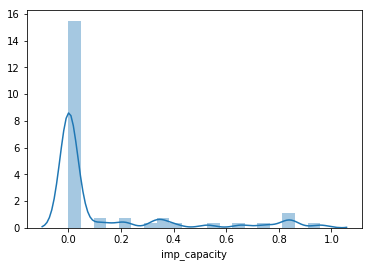

In [55]:
sns.distplot(trips_inefficiency.toPandas().imp_capacity)

#### System Recommendation Inefficiency I
$$
\begin{equation*}
    \frac{executed(fastest(Oe) - fastest(E)}{fastest(E)}
\end{equation*}
$$

In [45]:
w_rec_inef_i = Window().partitionBy(['date','user_trip_id']).orderBy(F.col('planned_duration_mins'))

shortest_planned_actual_duration = filtered_trips_itineraries \
                            .filter('itinerary_id > 0') \
                            .withColumn("rn", F.row_number().over(w_rec_inef_i)) \
                            .where(F.col("rn") == 1) \
                            .select('date','user_trip_id','planned_duration_mins','actual_duration_mins') \
                            .withColumnRenamed('planned_duration_mins','shortest_OTP_planned_duration') \
                            .withColumnRenamed('actual_duration_mins','shortest_OTP_actual_duration')

printdf(shortest_planned_actual_duration)

,date,user_trip_id,shortest_OTP_planned_duration,shortest_OTP_actual_duration
0,2017-05-09,489626271850,12.966667,12.983333
1,2017-05-09,970662608985,3.083333,1.966667
2,2017-05-09,1314259992844,25.316667,22.283333
3,2017-05-09,1297080123683,17.216667,15.050000
4,2017-05-09,1700807049484,17.300000,26.100000
5,2017-05-09,1005022347340,14.700000,11.650000
6,2017-05-09,575525617719,23.333333,27.850000
7,2017-05-09,1563368095850,41.633333,35.733333
8,2017-05-09,781684047908,26.033333,29.066667
9,2017-05-09,163208757335,3.800000,4.266667


In [47]:
rec_inef_i = filtered_trips_itineraries \
                .groupBy(['date','user_trip_id']) \
                .agg(F.min(F.col('actual_duration_mins')).alias('shortest_actual_duration')) \
                .join(shortest_planned_actual_duration, on=['date','user_trip_id'], how='inner') \
                .withColumn('rec_inef',(F.col('shortest_OTP_actual_duration') - F.col('shortest_actual_duration'))/F.col('shortest_OTP_actual_duration'))

printdf(rec_inef_i)

,date,user_trip_id,shortest_actual_duration,shortest_OTP_planned_duration,shortest_OTP_actual_duration,rec_inef
0,2017-05-09,489626271850,12.316667,12.966667,12.983333,0.051348
1,2017-05-09,970662608985,1.966667,3.083333,1.966667,0.000000
2,2017-05-09,1314259992844,22.283333,25.316667,22.283333,0.000000
3,2017-05-09,1297080123683,14.050000,17.216667,15.050000,0.066445
4,2017-05-09,1700807049484,14.933333,17.300000,26.100000,0.427842
5,2017-05-09,1005022347340,11.116667,14.700000,11.650000,0.045780
6,2017-05-09,575525617719,23.466667,23.333333,27.850000,0.157391
7,2017-05-09,1563368095850,30.350000,41.633333,35.733333,0.150653
8,2017-05-09,781684047908,27.533333,26.033333,29.066667,0.052752
9,2017-05-09,163208757335,4.266667,3.800000,4.266667,0.000000


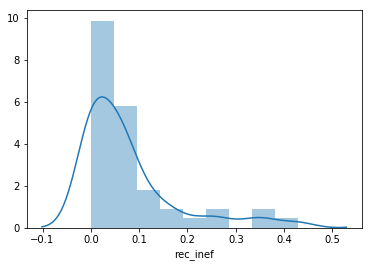

In [56]:
sns.distplot(rec_inef_i.toPandas().rec_inef)

#### System Recommendation Inefficiency II
$$
\begin{equation*}
    \frac{fastest(P) - fastest(E)}{fastest(E)}
\end{equation*}
$$

In [49]:
rec_inef_ii = filtered_trips_itineraries \
                .groupBy(['date','user_trip_id']) \
                .agg(F.min(F.col('actual_duration_mins')).alias('shortest_actual_duration')) \
                .join(shortest_planned_actual_duration, on=['date','user_trip_id'], how='inner') \
                .withColumn('rec_inef',(F.col('shortest_OTP_planned_duration') - F.col('shortest_actual_duration'))/F.col('shortest_OTP_planned_duration'))

printdf(rec_inef_ii)

,date,user_trip_id,shortest_actual_duration,shortest_OTP_planned_duration,shortest_OTP_actual_duration,rec_inef
0,2017-05-09,489626271850,12.316667,12.966667,12.983333,0.050129
1,2017-05-09,970662608985,1.966667,3.083333,1.966667,0.362162
2,2017-05-09,1314259992844,22.283333,25.316667,22.283333,0.119816
3,2017-05-09,1297080123683,14.050000,17.216667,15.050000,0.183930
4,2017-05-09,1700807049484,14.933333,17.300000,26.100000,0.136802
5,2017-05-09,1005022347340,11.116667,14.700000,11.650000,0.243764
6,2017-05-09,575525617719,23.466667,23.333333,27.850000,-0.005714
7,2017-05-09,1563368095850,30.350000,41.633333,35.733333,0.271017
8,2017-05-09,781684047908,27.533333,26.033333,29.066667,-0.057618
9,2017-05-09,163208757335,4.266667,3.800000,4.266667,-0.122807


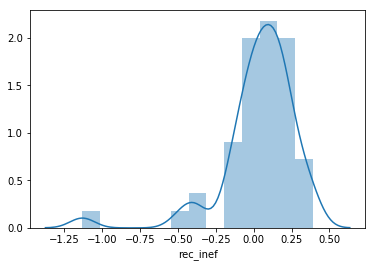

In [57]:
sns.distplot(rec_inef_ii.toPandas().rec_inef)

In [75]:
positive_rec_inef = rec_inef_ii[rec_inef_ii['rec_inef'] > 0]
print positive_rec_inef.count()/float(rec_inef_ii.count())
print np.nanmedian(positive_rec_inef.toPandas()['rec_inef'])

0.13680154142581891

In [76]:
negative_rec_inef = rec_inef_ii[rec_inef_ii['rec_inef'] < 0]
print negative_rec_inef.count()/float(rec_inef_ii.count())
print np.nanmedian(negative_rec_inef.toPandas()['rec_inef'])

0.340425531915
-0.124997978818


#### User choice plan inefficiency
$$
\begin{equation*}
    \frac{Up - fastest(P))}{Up}
\end{equation*}
$$

#### System Schedule Deviation
$$
\begin{equation*}
    {Oe - Op}
\end{equation*}
$$

In [81]:
sched_deviation = all_itineraries \
                    .filter('itinerary_id > 0') \
                    .withColumn('sched_dev',F.col('actual_duration_mins') - F.col('planned_duration_mins'))
    
printdf(sched_deviation)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,planned_start_time,actual_start_time,exec_duration_mins,exec_start_time,sched_dev
0,2017-05-09,1374389535030,1,16.983333,23.983333,2017-05-09 15:06:54,2017-05-09 15:02:56,52.666667,2017-05-09 15:03:49,7.000000
1,2017-05-09,1374389535030,2,17.466667,19.950000,2017-05-09 15:17:49,2017-05-09 15:17:38,52.666667,2017-05-09 15:03:49,2.483333
2,2017-05-09,1443109011501,1,26.483333,17.966667,2017-05-09 05:23:47,2017-05-09 05:22:50,17.166667,2017-05-09 05:22:54,-8.516667
3,2017-05-09,1443109011501,2,26.483333,18.116667,2017-05-09 05:42:47,2017-05-09 05:41:04,17.166667,2017-05-09 05:22:54,-8.366667
4,2017-05-09,420906795315,1,23.916667,28.150000,2017-05-09 18:04:28,2017-05-09 18:02:44,63.733333,2017-05-09 17:52:14,4.233333
5,2017-05-09,420906795315,2,23.916667,27.016667,2017-05-09 18:12:28,2017-05-09 18:13:43,63.733333,2017-05-09 17:52:14,3.100000
6,2017-05-09,858993459397,2,11.766667,14.183333,2017-05-09 07:54:21,2017-05-09 07:50:09,54.016667,2017-05-09 07:33:42,2.416667
7,2017-05-09,858993459397,3,12.166667,13.033333,2017-05-09 08:07:03,2017-05-09 08:06:19,54.016667,2017-05-09 07:33:42,0.866667
8,2017-05-09,455266533594,1,10.100000,13.833333,2017-05-09 13:55:14,2017-05-09 14:12:41,10.416667,2017-05-09 13:51:22,3.733333
9,2017-05-09,455266533594,2,11.000000,14.200000,2017-05-09 13:59:12,2017-05-09 13:55:11,10.416667,2017-05-09 13:51:22,3.200000


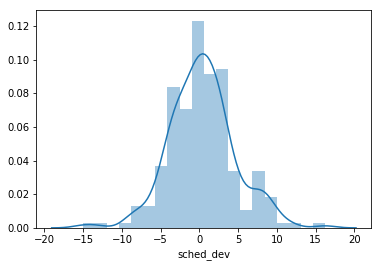

In [83]:
sns.distplot(sched_deviation.toPandas().sched_dev)

#### User Trip Schedule Deviation
$$
\begin{equation*}
    {Ue - Up}
\end{equation*}
$$

#### User stop waiting time offset
$$
\begin{equation*}
    {start(Oe) - start(Op)}
\end{equation*}
$$

In [86]:
user_boarding_timediff = all_itineraries \
                    .filter('itinerary_id > 0') \
                    .withColumn('boarding_timediff',(F.unix_timestamp('actual_start_time') - F.unix_timestamp('planned_start_time'))/60)
    
printdf(user_boarding_timediff)

,date,user_trip_id,itinerary_id,planned_duration_mins,actual_duration_mins,planned_start_time,actual_start_time,exec_duration_mins,exec_start_time,boarding_timediff
0,2017-05-09,1374389535030,1,16.983333,23.983333,2017-05-09 15:06:54,2017-05-09 15:02:56,52.666667,2017-05-09 15:03:49,-3.966667
1,2017-05-09,1374389535030,2,17.466667,19.950000,2017-05-09 15:17:49,2017-05-09 15:17:38,52.666667,2017-05-09 15:03:49,-0.183333
2,2017-05-09,1443109011501,1,26.483333,17.966667,2017-05-09 05:23:47,2017-05-09 05:22:50,17.166667,2017-05-09 05:22:54,-0.950000
3,2017-05-09,1443109011501,2,26.483333,18.116667,2017-05-09 05:42:47,2017-05-09 05:41:04,17.166667,2017-05-09 05:22:54,-1.716667
4,2017-05-09,420906795315,1,23.916667,28.150000,2017-05-09 18:04:28,2017-05-09 18:02:44,63.733333,2017-05-09 17:52:14,-1.733333
5,2017-05-09,420906795315,2,23.916667,27.016667,2017-05-09 18:12:28,2017-05-09 18:13:43,63.733333,2017-05-09 17:52:14,1.250000
6,2017-05-09,858993459397,2,11.766667,14.183333,2017-05-09 07:54:21,2017-05-09 07:50:09,54.016667,2017-05-09 07:33:42,-4.200000
7,2017-05-09,858993459397,3,12.166667,13.033333,2017-05-09 08:07:03,2017-05-09 08:06:19,54.016667,2017-05-09 07:33:42,-0.733333
8,2017-05-09,455266533594,1,10.100000,13.833333,2017-05-09 13:55:14,2017-05-09 14:12:41,10.416667,2017-05-09 13:51:22,17.450000
9,2017-05-09,455266533594,2,11.000000,14.200000,2017-05-09 13:59:12,2017-05-09 13:55:11,10.416667,2017-05-09 13:51:22,-4.016667


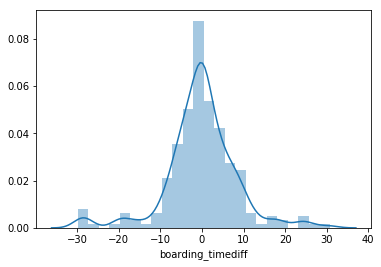

In [87]:
sns.distplot(user_boarding_timediff.toPandas().boarding_timediff)